In [1]:
!nvidia-smi

Fri Oct  8 12:31:34 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
import imutils
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator, array_to_img
from tensorflow.keras.applications import EfficientNetB1

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, Flatten, Dropout, Dense

In [3]:
train_dir = '/content/drive/MyDrive/STORK-master/STORK-master/Images/train'
test_dir = '/content/drive/MyDrive/STORK-master/STORK-master/Images/Images_test'


classes = os.listdir(train_dir) 
# classes = ['no_tumor', 'glioma_tumor', 'meningioma_tumor', 'pituitary_tumor']

os.mkdir('/content/Train-Data')
os.mkdir('/content/Test-Data')

for cls in classes:
  os.mkdir(f'/content/Train-Data/{cls}')
  os.mkdir(f'/content/Test-Data/{cls}')

In [4]:
classes


['good', 'poor']

In [5]:
train_files_path = {cls: list(map(lambda x: os.path.join(train_dir, cls, x), os.listdir(os.path.join(train_dir, cls)))) for cls in classes}

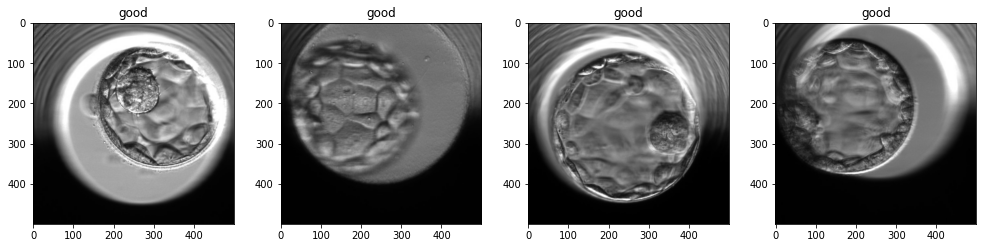

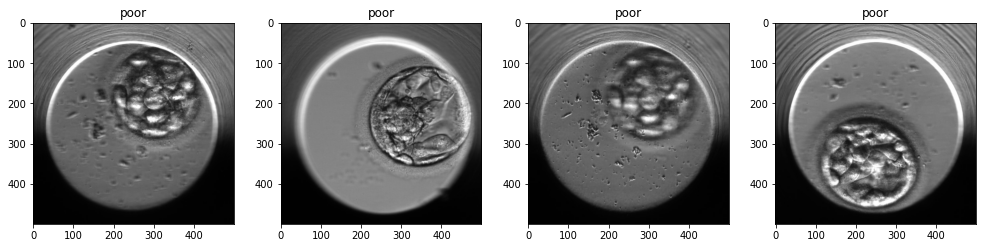

In [6]:
for cls in classes:
  plt.figure(figsize=(17, 17))
  random.shuffle(train_files_path[cls])
  files = train_files_path[cls][:5]

  for i in range(1, 5):
    plt.subplot(4, 4, i)
    plt.imshow(load_img(files[i]))
    plt.title(cls)

In [7]:
def crop_image(image, plot=False):
    
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    img_gray = cv2.GaussianBlur(img_gray, (5, 5), 0)
    
    img_thresh = cv2.threshold(img_gray, 45, 255, cv2.THRESH_BINARY)[1]
    img_thresh = cv2.erode(img_thresh, None, iterations=2)
    img_thresh = cv2.dilate(img_thresh, None, iterations=2)

    contours = cv2.findContours(img_thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    c = max(contours, key=cv2.contourArea)

    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()
    
    return new_image

In [8]:
train_class_paths = [os.path.join(train_dir, cls) for cls in classes]

test_class_paths = [os.path.join(test_dir, cls) for cls in classes]

In [9]:
def crop_img_saver(class_read_paths, save_dir):
  save_root = '/content'

  for cls in class_read_paths:
    for i, p in tqdm(enumerate(os.listdir(cls))):
      path = os.path.join(cls, p)
      img = crop_image(cv2.imread(path), plot=False)

      if img is not None:
        img = cv2.resize(img, (224, 224))
        save_class = cls.split('/')[-1]
        save_path = os.path.join(save_root, save_dir, save_class, f'{str(i)}.jpg')
        cv2.imwrite(save_path, img)

In [10]:
crop_img_saver(train_class_paths, save_dir='Train-Data')

crop_img_saver(test_class_paths, save_dir='Test-Data')

42it [00:28,  1.47it/s]
42it [00:27,  1.52it/s]
7it [00:05,  1.33it/s]
7it [00:04,  1.43it/s]


In [13]:
train_data_generator = ImageDataGenerator(rotation_range=10, 
                                          height_shift_range=0.2, 
                                          horizontal_flip=True, 
                                          validation_split=0.2)

train_data = train_data_generator.flow_from_directory('/content/Train-Data/',
                                                      target_size=(224, 224),
                                                      batch_size=32,
                                                      class_mode='categorical',
                                                      subset='training')

validation_data = train_data_generator.flow_from_directory('/content/Train-Data',
                                                           target_size=(224, 224),
                                                           batch_size=32,
                                                           class_mode='categorical',
                                                           subset='validation')

test_data_generator = ImageDataGenerator()

test_data = test_data_generator.flow_from_directory('/content/Test-Data/',
                                        target_size=(224, 224),
                                        class_mode='categorical')

Found 68 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 14 images belonging to 2 classes.


In [12]:
print(train_data.class_indices, test_data.class_indices, sep='\n')

{'good': 0, 'poor': 1}
{'good': 0, 'poor': 1}


/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


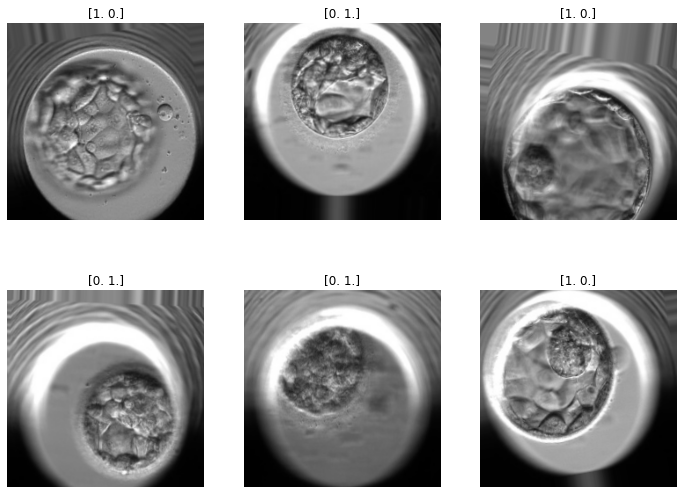

In [14]:
sample_x, sample_y = next(train_data)
plt.figure(figsize=(12, 9))
for i in range(6):
  plt.subplot(2, 3, i+1)
  plt.axis('off'), plt.grid(False)
  # sample_img = array_to_img(sample_x[i])
  plt.imshow(array_to_img(sample_x[i]))
  plt.title(sample_y[i])

In [16]:
effnet = EfficientNetB1(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

model = effnet.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.5)(model)
model = Dense(2, activation='softmax')(model)
model = Model(inputs=effnet.input, outputs=model)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 224, 224, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
normalization_1 (Normalization) (None, 224, 224, 3)  7           rescaling_1[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization_1[0][0]            
____________________________________________________________________________________________

In [17]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                  patience=5,
                                                  mode='auto',
                                                  verbose=1)

checkpoint = tf.keras.callbacks.ModelCheckpoint('model_ckpt.h5', 
                                                monitor='val_accuracy',
                                                save_best_only=True,
                                                mode='auto',
                                                verbose=1)

In [18]:
history = model.fit(train_data, 
                    epochs=10, 
                    validation_data=validation_data, 
                    callbacks=[checkpoint, early_stopping], 
                    verbose=1)

Epoch 1/10
3/3 [==============================] - 52s 3s/step - loss: 0.6758 - accuracy: 0.6176 - val_loss: 0.4274 - val_accuracy: 0.8125

Epoch 00001: val_accuracy improved from -inf to 0.81250, saving model to model_ckpt.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/10
3/3 [==============================] - 2s 1s/step - loss: 0.5474 - accuracy: 0.7059 - val_loss: 0.3728 - val_accuracy: 1.0000

Epoch 00002: val_accuracy improved from 0.81250 to 1.00000, saving model to model_ckpt.h5
Epoch 3/10
3/3 [==============================] - 2s 1s/step - loss: 0.3888 - accuracy: 0.8676 - val_loss: 0.3682 - val_accuracy: 0.9375

Epoch 00003: val_accuracy did not improve from 1.00000
Epoch 4/10
3/3 [==============================] - 2s 1s/step - loss: 0.4342 - accuracy: 0.8235 - val_loss: 0.3255 - val_accuracy: 0.9375

Epoch 00004: val_accuracy did not improve from 1.00000
Epoch 5/10
3/3 [==============================] - 3s 772ms/step - loss: 0.3068 - accuracy: 0.8824 - val_loss: 0.2759 - val_accuracy: 0.9375

Epoch 00005: val_accuracy did not improve from 1.00000
Epoch 6/10
3/3 [==============================] - 3s 762ms/step - loss: 0.1875 - accuracy: 0.9706 - val_loss: 0.2598 - val_accuracy: 0.9375

Epoch 00006: val_accuracy did not improve from 1.

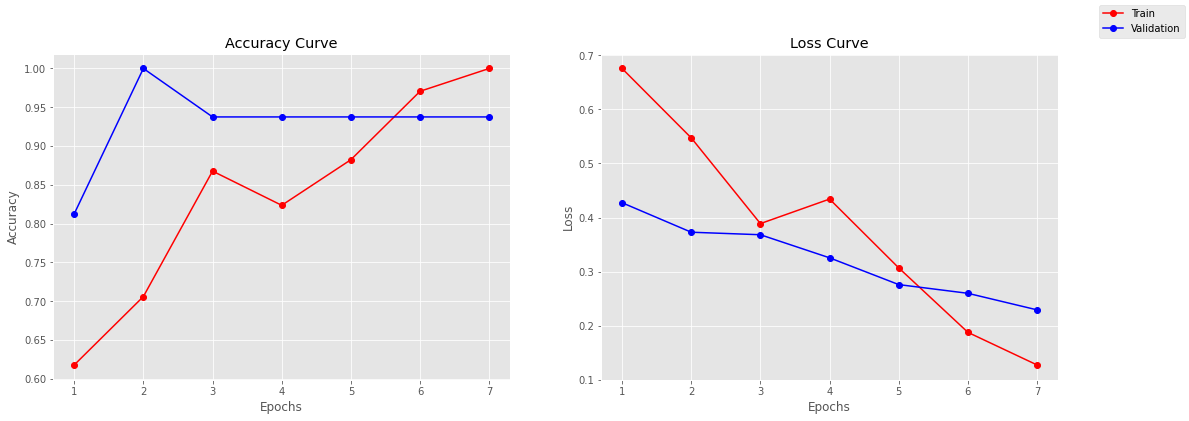

In [21]:
plt.style.use('ggplot')
figure = plt.figure(figsize=(18, 6))
epochs = range(1, 8)

plt.subplot(121)
plt.plot(epochs, history.history['accuracy'], 'ro-')
plt.plot(epochs, history.history['val_accuracy'], 'bo-')
plt.xlabel('Epochs'), plt.ylabel('Accuracy'), plt.title('Accuracy Curve')

plt.subplot(122)
plt.plot(epochs, history.history['loss'], 'ro-')
plt.plot(epochs, history.history['val_loss'], 'bo-')
plt.xlabel('Epochs'), plt.ylabel('Loss'), plt.title('Loss Curve')

figure.legend(['Train', 'Validation'])

In [22]:
model.evaluate(test_data)

1/1 [==============================] - 1s 918ms/step - loss: 0.4402 - accuracy: 0.8571


[0.44021448493003845, 0.8571428656578064]

Model prediction probabilities: [[0.27094248 0.7290575 ]]
Output Class Label: 1
Predicted Class: poor
Image name: poor_27002081_-30_1BB.jpg 

Model prediction probabilities: [[0.30874023 0.6912598 ]]
Output Class Label: 1
Predicted Class: poor
Image name: poor_27002081_-15_1BB.jpg 

Model prediction probabilities: [[0.37150908 0.6284909 ]]
Output Class Label: 1
Predicted Class: poor
Image name: poor_27002081_0_1BB.jpg 

Model prediction probabilities: [[0.5086862 0.4913138]]
Output Class Label: 0
Predicted Class: good
Image name: good_23765483_45_3AA.jpg 

Model prediction probabilities: [[0.43001598 0.56998396]]
Output Class Label: 1
Predicted Class: poor
Image name: good_23765483_-45_3AA.jpg 

Model prediction probabilities: [[0.41245446 0.5875455 ]]
Output Class Label: 1
Predicted Class: poor
Image name: poor_27002081_-45_1BB.jpg 

Model prediction probabilities: [[0.20115672 0.7988433 ]]
Output Class Label: 1
Predicted Class: poor
Image name: poor_27002081_30_1BB.jpg 

Model predic

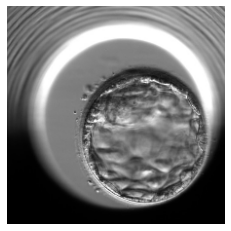

In [37]:
label_map = {v: k for k, v in test_data.class_indices.items()}

test_images_path = '/content/drive/MyDrive/STORK-master/STORK-master/Images/test/'

for i in os.listdir(test_images_path):
  test_image = cv2.imread(test_images_path + i)
  test_image = cv2.resize(test_image, (224, 224))
  plt.grid(0), plt.axis('off')
  plt.imshow(test_image)
  test_image = np.expand_dims(test_image, axis=0)

  pred = model.predict(test_image)
  print(f'Model prediction probabilities: {pred}')
  pred = np.argmax(pred)
  print(f'Output Class Label: {pred}')
  pred = label_map[pred]
  print(f'Predicted Class: {pred}')
  print(f'Image name: {i} \n')